In [1]:
from collections import defaultdict
from datetime import datetime
import kaleido  # needed for saving plots
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from regression import *

In [2]:
results_dir = 'results/benchmark/14Aug/'
os.makedirs(results_dir, exist_ok=True)

In [3]:
def save_plot(fig, folder, filename, extensions=['png', 'svg', 'pdf'], scale=2):
    for ext in extensions:
        fig.write_image(folder + filename + '.' + ext, scale=scale)
    fig.write_html(folder + filename + '.html')

# Prepare data

In [4]:
url = "https://docs.google.com/spreadsheets/d/1etu9rXcME0uUA-S2ANA8bsfQbIZgNu-8NxqFGQdDIzQ/export?format=csv&gid=1305280917#gid=1305280917"
df = pd.read_csv(url)
df

,System,Model size (parameters),Dataset size,Date,Open/Closed,Training compute (FLOP),Training compute notes,BBH,GPQA,MMLU,...,SEAL Math,LMSys Elo,LMSys Elo Notes,LMSys Elo 95% CI,BBH Notes,GPQA Notes,MMLU Notes,HELM MMLU Notes,Trust in benchmark results,Trust notes
0,Random chance,NaN,NaN,NaN,NaN,1.000000e+20,NaN,0.2500,0.250,0.2500,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,BLOOM-176B,1.760000e+11,3.900000e+11,2022-11-09,Open,4.120000e+23,NaN,0.4491,NaN,0.3913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,BloombergGPT,5.000000e+10,7.080000e+11,2023-03-30,Closed,2.120000e+23,NaN,0.4197,NaN,0.3918,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,Camelidae-8x34B,NaN,NaN,2024-01-05,Open,NaN,NaN,NaN,NaN,0.7560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ChatGLM-6B,6.000000e+09,NaN,2023-03-01,Open,NaN,NaN,0.1873,NaN,NaN,...,NaN,880.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,XVerse-65B,NaN,NaN,2023-11-05,Open,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
106,XVerse-7B,NaN,NaN,2023-09-26,Open,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
107,Yi-34B,3.400000e+10,3.000000e+12,2023-11-02,Open,6.120000e+23,NaN,0.5430,0.370,0.7635,...,NaN,1111.0,chat,NaN,NaN,"Not sure this is zero-shot CoT, OpenLLM2 Leade...",NaN,NaN,0.0,NaN
108,Yi-6B,6.000000e+09,3.000000e+12,2023-11-02,Open,1.080000e+23,NaN,0.4280,NaN,0.6385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [5]:
url = "https://docs.google.com/spreadsheets/d/1KYp4h3urj-698IE9bR7n1ctuH1iyCAQ5pTZIqQ_qs9g/export?format=csv"
gsm1k_df = pd.read_csv(url)
gsm1k_df

,model,Date,gsm8k,gsm1k,Compute,Speculative Compute,Open weights?
0,claude-2.1,2023-07-11,88.7,89.4,3.800000e+24,NaN,n
1,claude-3-haiku-20240307,2024-03-04,78.5,78.5,NaN,NaN,n
2,claude-3-opus-20240229,2024-03-04,80.2,82.5,NaN,4.000000e+25,n
3,claude-3-sonnet-20240229,2024-03-04,71.9,74.4,NaN,NaN,n
4,codegemma-7b,2024-04-09,47.9,41.6,3.330000e+23,NaN,y
...,...,...,...,...,...,...,...
66,vicuna-33b-v1.3,2023-06-22,37.9,34.1,NaN,NaN,y
67,Xwin-Math-13B-V1.0,2024-03-07,63.1,52.9,NaN,NaN,NaN
68,Xwin-Math-7B-V1.0,2024-03-07,52.9,42.8,NaN,NaN,NaN
69,Yi-34B-Chat,2023-11-02,64.1,56.9,6.100000e+23,NaN,y


In [6]:
# Rename columns
gsm1k_df.rename(columns={'model': 'System', 'gsm8k': 'GSM8k', 'gsm1k': 'GSM1k', 'Compute': 'Training compute (FLOP)', 'Open weights?': 'Open/Closed'}, inplace=True)
gsm1k_df

,System,Date,GSM8k,GSM1k,Training compute (FLOP),Speculative Compute,Open/Closed
0,claude-2.1,2023-07-11,88.7,89.4,3.800000e+24,NaN,n
1,claude-3-haiku-20240307,2024-03-04,78.5,78.5,NaN,NaN,n
2,claude-3-opus-20240229,2024-03-04,80.2,82.5,NaN,4.000000e+25,n
3,claude-3-sonnet-20240229,2024-03-04,71.9,74.4,NaN,NaN,n
4,codegemma-7b,2024-04-09,47.9,41.6,3.330000e+23,NaN,y
...,...,...,...,...,...,...,...
66,vicuna-33b-v1.3,2023-06-22,37.9,34.1,NaN,NaN,y
67,Xwin-Math-13B-V1.0,2024-03-07,63.1,52.9,NaN,NaN,NaN
68,Xwin-Math-7B-V1.0,2024-03-07,52.9,42.8,NaN,NaN,NaN
69,Yi-34B-Chat,2023-11-02,64.1,56.9,6.100000e+23,NaN,y


In [7]:
gsm1k_df['Open/Closed'] = gsm1k_df['Open/Closed'].map({'y': 'Open', 'n': 'Closed'})
gsm1k_df

,System,Date,GSM8k,GSM1k,Training compute (FLOP),Speculative Compute,Open/Closed
0,claude-2.1,2023-07-11,88.7,89.4,3.800000e+24,NaN,Closed
1,claude-3-haiku-20240307,2024-03-04,78.5,78.5,NaN,NaN,Closed
2,claude-3-opus-20240229,2024-03-04,80.2,82.5,NaN,4.000000e+25,Closed
3,claude-3-sonnet-20240229,2024-03-04,71.9,74.4,NaN,NaN,Closed
4,codegemma-7b,2024-04-09,47.9,41.6,3.330000e+23,NaN,Open
...,...,...,...,...,...,...,...
66,vicuna-33b-v1.3,2023-06-22,37.9,34.1,NaN,NaN,Open
67,Xwin-Math-13B-V1.0,2024-03-07,63.1,52.9,NaN,NaN,NaN
68,Xwin-Math-7B-V1.0,2024-03-07,52.9,42.8,NaN,NaN,NaN
69,Yi-34B-Chat,2023-11-02,64.1,56.9,6.100000e+23,NaN,Open


In [8]:
# Convert percentage to fraction
gsm1k_df['GSM1k'] /= 100
gsm1k_df['GSM8k'] /= 100

In [9]:
# Concatenate gsm1k_df and df
df = pd.concat([gsm1k_df, df], axis=0, join='outer', ignore_index=True)
df

,System,Date,GSM8k,GSM1k,Training compute (FLOP),Speculative Compute,Open/Closed,Model size (parameters),Dataset size,Training compute notes,...,SEAL Math,LMSys Elo,LMSys Elo Notes,LMSys Elo 95% CI,BBH Notes,GPQA Notes,MMLU Notes,HELM MMLU Notes,Trust in benchmark results,Trust notes
0,claude-2.1,2023-07-11,0.887,0.894,3.800000e+24,NaN,Closed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,claude-3-haiku-20240307,2024-03-04,0.785,0.785,NaN,NaN,Closed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,claude-3-opus-20240229,2024-03-04,0.802,0.825,NaN,4.000000e+25,Closed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,claude-3-sonnet-20240229,2024-03-04,0.719,0.744,NaN,NaN,Closed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,codegemma-7b,2024-04-09,0.479,0.416,3.330000e+23,NaN,Open,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,XVerse-65B,2023-11-05,NaN,NaN,NaN,NaN,Open,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
177,XVerse-7B,2023-09-26,NaN,NaN,NaN,NaN,Open,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
178,Yi-34B,2023-11-02,NaN,NaN,6.120000e+23,NaN,Open,3.400000e+10,3.000000e+12,NaN,...,NaN,1111.0,chat,NaN,NaN,"Not sure this is zero-shot CoT, OpenLLM2 Leade...",NaN,NaN,0.0,NaN
179,Yi-6B,2023-11-02,NaN,NaN,1.080000e+23,NaN,Open,6.000000e+09,3.000000e+12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [10]:
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df

,System,Date,GSM8k,GSM1k,Training compute (FLOP),Speculative Compute,Open/Closed,Model size (parameters),Dataset size,Training compute notes,...,SEAL Math,LMSys Elo,LMSys Elo Notes,LMSys Elo 95% CI,BBH Notes,GPQA Notes,MMLU Notes,HELM MMLU Notes,Trust in benchmark results,Trust notes
0,claude-2.1,2023-07-11,0.887,0.894,3.800000e+24,NaN,Closed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,claude-3-haiku-20240307,2024-03-04,0.785,0.785,NaN,NaN,Closed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,claude-3-opus-20240229,2024-03-04,0.802,0.825,NaN,4.000000e+25,Closed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,claude-3-sonnet-20240229,2024-03-04,0.719,0.744,NaN,NaN,Closed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,codegemma-7b,2024-04-09,0.479,0.416,3.330000e+23,NaN,Open,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,XVerse-65B,2023-11-05,NaN,NaN,NaN,NaN,Open,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
177,XVerse-7B,2023-09-26,NaN,NaN,NaN,NaN,Open,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
178,Yi-34B,2023-11-02,NaN,NaN,6.120000e+23,NaN,Open,3.400000e+10,3.000000e+12,NaN,...,NaN,1111.0,chat,NaN,NaN,"Not sure this is zero-shot CoT, OpenLLM2 Leade...",NaN,NaN,0.0,NaN
179,Yi-6B,2023-11-02,NaN,NaN,1.080000e+23,NaN,Open,6.000000e+09,3.000000e+12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [11]:
# Filter out finetuned systems

finetuned_systems = [
 'Layer Normalization: Handwriting sequence generation',
 'ULM-FiT',
 'ADP-FAIRSEQ + NGRAMRES',
 'Cross-lingual alignment',
 'UnifiedQA',
 '$\\infty$-former (SM)',
 'FLAN 137B',
 'AlphaFold-Multimer',
 'Masked Autoencoders',
 'Contriever',
 'BERT-RBP',
 'Minerva',
 'BlenderBot 3',
 'PaLM-SayCan',
 'NMST+GPT-2',
 'Decaying Fast Weights Transformer (WT-103)',
 'GPT-2 + Progressive LRD',
 'U-PaLM',
 'Flan-T5 11B',
 'Flan-PaLM 540B',
 'Taiyi-Stable Diffusion',
 'OPT-IML (175B)',
 'SparseOPT-175B',
 'DiT-XL/2',
 'VideoMAE V2',
 'Segment Anything Model',
 'gLM',
 'MOSS-Moon-003',
 'WizardLM-7B',
 'InstructBLIP',
 'Guanaco-65B',
 'WizardCoder-15.5B',
 'Code Llama-34B',
 'Code Llama-7B',
 'TigerBot-70B',
 'MiniGPT4 (Vicuna finetune)',
 'LLaMA-7B (protein-oriented instructions finetuned)',
 'FinGPT-13B',
 'LLaVA 1.5',
 'CogVLM',
 'Volcano 13B',
 'SPHINX (Llama 2 13B)',
 'Orca 2-13B',
 'Llama Guard',
 'FunSearch',
 'Elyza',
 'Code Llama-70B',
 'Swallow'
]

df = df[~df['System'].isin(finetuned_systems)]
df = df[~df['System'].str.contains('Flan')]
df = df[~df['System'].str.contains('FLAN')]

## Merge SEAL Math with GSM1k

In [12]:
for i, row in df.iterrows():
  if pd.notna(row['SEAL Math']):
    df.at[i, 'GSM1k'] = row['SEAL Math']
df

,System,Date,GSM8k,GSM1k,Training compute (FLOP),Speculative Compute,Open/Closed,Model size (parameters),Dataset size,Training compute notes,...,SEAL Math,LMSys Elo,LMSys Elo Notes,LMSys Elo 95% CI,BBH Notes,GPQA Notes,MMLU Notes,HELM MMLU Notes,Trust in benchmark results,Trust notes
0,claude-2.1,2023-07-11,0.887,0.894,3.800000e+24,NaN,Closed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,claude-3-haiku-20240307,2024-03-04,0.785,0.785,NaN,NaN,Closed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,claude-3-opus-20240229,2024-03-04,0.802,0.825,NaN,4.000000e+25,Closed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,claude-3-sonnet-20240229,2024-03-04,0.719,0.744,NaN,NaN,Closed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,codegemma-7b,2024-04-09,0.479,0.416,3.330000e+23,NaN,Open,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,XVerse-65B,2023-11-05,NaN,NaN,NaN,NaN,Open,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
177,XVerse-7B,2023-09-26,NaN,NaN,NaN,NaN,Open,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
178,Yi-34B,2023-11-02,NaN,NaN,6.120000e+23,NaN,Open,3.400000e+10,3.000000e+12,NaN,...,NaN,1111.0,chat,NaN,NaN,"Not sure this is zero-shot CoT, OpenLLM2 Leade...",NaN,NaN,0.0,NaN
179,Yi-6B,2023-11-02,NaN,NaN,1.080000e+23,NaN,Open,6.000000e+09,3.000000e+12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


# MMLU vs. GPQA

In [13]:
df['MMLU (log-ratio)'] = -np.log(1/df['MMLU'] - 1)
df['GPQA (log-ratio)'] = -np.log(1/df['GPQA'] - 1)

In [14]:
color_map = {'Open': 'blue', 'Closed': 'darkorange'}

# Create the plot
fig = px.scatter(df, x='MMLU (log-ratio)', y='GPQA (log-ratio)', color='Open/Closed',
                 title='MMLU vs. GPQA for Open and Closed Models',
                 labels={'MMLU': 'MMLU Score', 'GPQA': 'GPQA Score', 'Date': 'Date', 'System': 'Model'},
                 hover_data=['System', 'Date', 'MMLU', 'GPQA'],
                 color_discrete_map=color_map)

# x limits
# fig.update_xaxes(range=[0.6, 1])
fig.update_xaxes(range=[0.5, 2.5])

# Improve the layout
fig.update_layout(
    width=800,
    height=400,
    xaxis_title="MMLU (log-ratio)",
    yaxis_title="GPQA (log-ratio)",
    legend_title="Model accessibility",
    font=dict(size=12),
    hovermode="closest"
)

# Show the plot
fig.show()

# LMSys leaderboard

In [15]:
lmsys_leaderboard_bootstrap_elo_lu = pd.read_csv('https://docs.google.com/spreadsheets/d/12zpanuQ1Vf_ZsZ6yjIUwsN7uGPBv3ChLnEOH-g9yZDA/export?format=csv')
lmsys_leaderboard_bootstrap_elo_lu = lmsys_leaderboard_bootstrap_elo_lu.iloc[:, 1:]  # remove first column which is meaningless
lmsys_leaderboard_bootstrap_elo_lu

,gpt-4o-2024-05-13,gpt-4o-mini-2024-07-18,claude-3-5-sonnet-20240620,gemini-advanced-0514,llama-3.1-405b-instruct,gemini-1.5-pro-api-0514,gemini-1.5-pro-api-0409-preview,gpt-4-turbo-2024-04-09,gpt-4-1106-preview,claude-3-opus-20240229,...,mpt-7b-chat,chatglm2-6b,RWKV-4-Raven-14B,alpaca-13b,oasst-pythia-12b,chatglm-6b,fastchat-t5-3b,stablelm-tuned-alpha-7b,dolly-v2-12b,llama-13b
0,1286.563455,1279.608815,1274.564379,1266.819548,1263.930629,1262.800113,1256.751200,1259.245346,1251.302638,1246.760897,...,924.081608,930.543839,918.995447,901.694532,895.192400,883.743569,867.977489,837.073711,818.981457,808.397845
1,1288.428940,1287.494945,1274.828503,1268.867005,1263.724865,1263.094929,1258.320223,1258.824223,1252.959457,1250.215882,...,935.186934,920.658893,920.372902,902.614513,894.466683,882.769816,864.055190,840.495344,834.205668,808.046396
2,1287.656293,1281.667695,1275.934504,1268.043471,1261.739568,1261.318913,1258.466691,1258.400212,1254.262636,1250.576760,...,929.251400,923.474876,922.648498,902.220662,894.705996,882.850605,866.929706,847.122558,827.818429,800.490271
3,1284.869154,1279.653476,1269.833920,1270.960974,1269.859096,1260.875571,1257.971376,1257.228266,1251.218192,1249.384635,...,924.035959,922.679121,927.995020,907.170559,897.610422,886.338026,869.905058,842.907147,822.159108,802.589771
4,1285.265726,1282.100890,1268.621384,1266.144561,1262.945738,1260.335847,1257.264334,1257.701172,1248.990652,1247.745614,...,932.584454,915.986844,925.938795,907.229511,892.749966,885.482519,870.742351,844.870609,836.226871,792.792144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1285.964492,1276.413219,1272.279060,1265.682928,1259.271852,1259.780934,1257.705533,1255.287783,1253.316087,1249.462305,...,923.560224,923.189484,917.675145,905.453634,895.762404,881.942653,870.194162,848.375467,827.956177,791.777917
96,1285.769193,1280.955978,1272.596400,1265.313367,1265.510474,1259.210643,1257.968203,1255.820464,1249.073128,1246.840205,...,926.643587,917.478913,922.521962,902.473931,895.742491,876.732514,866.833976,841.230148,817.499211,799.746847
97,1283.361066,1279.543617,1269.244543,1263.704350,1262.416331,1258.528302,1255.166021,1256.156088,1249.962949,1247.240214,...,923.772273,912.598287,917.762886,891.914471,893.081979,872.800000,861.065138,833.636823,818.914647,789.664182
98,1286.871546,1280.301802,1271.749040,1270.644211,1260.150249,1261.494653,1257.594055,1259.429122,1253.718693,1249.689318,...,920.938684,935.274025,917.555680,900.601728,889.143356,884.380531,866.582044,840.679533,821.720833,802.801129


In [16]:
# Alphabetical order
lmsys_leaderboard_bootstrap_elo_lu.mean().round().sort_index()

RWKV-4-Raven-14B               922.0
alpaca-13b                     902.0
athene-70b-0725               1246.0
bard-jan-24-gemini-pro        1208.0
chatglm-6b                     880.0
                               ...  
yi-large                      1212.0
yi-large-preview              1240.0
zephyr-7b-alpha               1042.0
zephyr-7b-beta                1053.0
zephyr-orpo-141b-A35b-v0.1    1126.0
Length: 120, dtype: float64

## Trust in evaluations

In [17]:
# Models whose evaluations we have a concrete reason to distrust
list(df[df['Trust in benchmark results'] < 0]['System'])

['DBRX-Instruct',
 'DeepSeek-67B',
 'Falcon 180B',
 'gpt-4-0125-preview',
 'gpt-4-0613',
 'Llama 3 8B',
 'Mistral-7B',
 'Mixtral8x22B',
 'Reka Core']

In [18]:
# Models whose evaluations we have a concrete reason to trust
list(df[df['Trust in benchmark results'] > 0]['System'])

['Claude 2',
 'Claude 3 Opus',
 'Claude 3 Sonnet',
 'Gemini 1.0 Pro',
 'Gemini 1.5 Pro (April 2024)',
 'GPT-3.5-turbo-16k',
 'GPT-4 (original)',
 'gpt-4-turbo-2024-04-09',
 'Llama 3 70B',
 'Mistral Large']

# Plot benchmark data

In [19]:
# benchmarks_to_plot = ['MMLU', 'GPQA', 'GSM1k', 'BBH']
benchmarks_to_plot = ['LMSys Elo', 'SEAL Coding']
bench_is_accuracy = {'MMLU': True, 'BBH': True, 'GSM1k': True, 'GPQA': True, 'LMSys Elo': False, 'SEAL Coding': False, 'SEAL Math': False}
plot_log_error = True
non_suspects_only = True
trusted_only = False
old_models_only = False
new_models_only = False
show_model_age = False
save = True

color_map = {'Open': 'blue', 'Closed': 'darkorange'}
marker_map = {'Before': 'circle', 'After': 'diamond'}

In [20]:
df['Before November 2023'] = ['Before' if pd.to_datetime(row['Date']) < pd.to_datetime('2023-11-01') else 'After' for i, row in df.iterrows()]

In [21]:
df[df['System'] == 'Random chance']['Date']

71   NaT
Name: Date, dtype: datetime64[ns]

## Date

In [22]:
lags = defaultdict(list)
for i, bench in enumerate(benchmarks_to_plot):
  print(bench)
  plot_df = df[~(df['System'] == 'Random chance')]
  if old_models_only:
    plot_df = plot_df[plot_df['Before November 2023'] == 'Before']
  elif new_models_only:
    plot_df = plot_df[plot_df['Before November 2023'] == 'After']
  if non_suspects_only:
    if bench == 'GPQA':
      # GPQA was released November 20, 2023
      old_df = plot_df[plot_df['Before November 2023'] == 'Before']
      new_df = plot_df[plot_df['Before November 2023'] == 'After']
      new_df = new_df[new_df['Trust in benchmark results'] >= 0]
      plot_df = pd.concat([old_df, new_df])
    elif bench == 'MMLU':
      plot_df = plot_df[plot_df['Trust in benchmark results'] >= 0]
  elif trusted_only:
    plot_df = plot_df[plot_df['Trust in benchmark results'] > 0]

  plot_df = plot_df.sort_values('Date')
  max_rows = defaultdict(list)
  for category in ['Open', 'Closed']:
    category_df = plot_df[plot_df['Open/Closed'] == category]
    max_score = 0
    for i, row in category_df.iterrows():
      score = -np.log(1 - row[bench])
      if score > max_score:
        max_score = score
        max_row = {'Date': row['Date'], 'System': row['System'], 'Score': score}
        max_rows[category].append(max_row)

  noise_tolerance = 0.1 # nats
  already_matched = set()
  for closed_row in max_rows['Closed']:
    for open_row in max_rows['Open']:
      if open_row['Score'] > (closed_row['Score'] - noise_tolerance) and open_row['Date'] not in already_matched:
        lag_months = (open_row['Date'] - closed_row['Date']).days/365*12
        
        print(f"{open_row['System']} at {open_row['Score']:.2f} matched or exceeded " + 
              f"{closed_row['System']} at {closed_row['Score']:.2f} after " + 
              f"{lag_months:.1f} months")
        already_matched.add(open_row['Date'])
        lags[bench].append(lag_months)
        break

  print(f"{bench} mean lag: {np.mean(lags[bench]):.1f} months\n")

lags

MMLU
GPT-NeoX 20B at 0.41 matched or exceeded text-davinci-001 at 0.51 after 20.4 months
LLaMa-2 70B at 1.17 matched or exceeded code-davinci-002 at 1.15 after 16.6 months
Yi-34B at 1.44 matched or exceeded PaLM 540B at 1.25 after 19.0 months
Llama 3.1 405B at 2.06 matched or exceeded GPT-4 (original) at 2.00 after 16.3 months
MMLU mean lag: 18.1 months

GPQA
Yi-34B at 0.46 matched or exceeded GPT-3.5-turbo-16k at 0.33 after 4.7 months
Llama 3 70B at 0.53 matched or exceeded gpt-4-0613 at 0.44 after 10.2 months
Nemotron-4-340B Instruct at 0.55 matched or exceeded Claude 3 Sonnet at 0.52 after 3.4 months
Llama 3.1 70B at 0.63 matched or exceeded Claude 3 Opus at 0.70 after 4.6 months
GPQA mean lag: 5.7 months

GSM1k
Smaug-2-72B at 1.34 matched or exceeded gpt-3.5-turbo at 1.40 after 9.5 months
Llama 3 70B at 2.31 matched or exceeded claude-2.1 at 2.24 after 9.3 months
Llama 3.1 405B at 3.12 matched or exceeded gpt-4-0125-preview at 3.02 after 5.9 months
GSM1k mean lag: 8.2 months

BBH
T

defaultdict(list,
            {'MMLU': [20.449315068493153,
              16.56986301369863,
              18.96986301369863,
              16.306849315068494],
             'GPQA': [4.668493150684932,
              10.191780821917808,
              3.353424657534247,
              4.635616438356164],
             'GSM1k': [9.534246575342465,
              9.271232876712329,
              5.917808219178082],
             'BBH': [-7.167123287671233,
              20.449315068493153,
              29.424657534246577,
              16.56986301369863,
              5.58904109589041,
              3.353424657534247]})

In [67]:
fig = make_subplots(rows=2, cols=2, subplot_titles=benchmarks_to_plot, vertical_spacing=0.2, horizontal_spacing=0.2)

# Define x limits for each subplot
x_limits = {
  'MMLU': [datetime(2020, 1, 1), datetime(2025, 1, 1)],
  'BBH': [datetime(2020, 1, 1), datetime(2025, 1, 1)],
  'GSM1k': [datetime(2023, 1, 1), datetime(2025, 1, 1)],
  'GPQA': [datetime(2023, 1, 1), datetime(2025, 1, 1)],
  'SEAL Coding': [datetime(2023, 1, 1), datetime(2025, 1, 1)],
  'SEAL Math': [datetime(2023, 1, 1), datetime(2025, 1, 1)],
  'LMSys Elo': [datetime(2023, 1, 1), datetime(2025, 1, 1)],
}

for i, bench in enumerate(benchmarks_to_plot):
  plot_df = df[~(df['System'] == 'Random chance')]
  if old_models_only:
    plot_df = plot_df[plot_df['Before November 2023'] == 'Before']
  elif new_models_only:
    plot_df = plot_df[plot_df['Before November 2023'] == 'After']
  if non_suspects_only:
    if bench == 'GPQA':
      # GPQA was released November 20, 2023
      old_df = plot_df[plot_df['Before November 2023'] == 'Before']
      new_df = plot_df[plot_df['Before November 2023'] == 'After']
      new_df = new_df[new_df['Trust in benchmark results'] >= 0]
      plot_df = pd.concat([old_df, new_df])
    elif bench == 'MMLU':
      plot_df = plot_df[plot_df['Trust in benchmark results'] >= 0]
  elif trusted_only:
    plot_df = plot_df[plot_df['Trust in benchmark results'] > 0]

  for category in ['Open', 'Closed']:
    category_df = plot_df[plot_df['Open/Closed'] == category]

    # Sort by date (needed for running max)
    category_df = category_df.sort_values('Date')
    # Calculate running max
    category_df['running_max'] = category_df[bench].cummax()
    
    # Create a new dataframe with all dates, filling in gaps
    date_range = pd.date_range(start=category_df['Date'].min(), end=category_df['Date'].max(), freq='D')
    full_df = pd.DataFrame({'Date': date_range})
    full_df = full_df.merge(category_df[['Date', 'running_max', 'System']], on='Date', how='left')
    
    # Forward fill the running max and system name
    full_df['running_max'] = full_df['running_max'].ffill()
    full_df['System'] = full_df['System'].ffill()

    if plot_log_error and bench_is_accuracy[bench]:
      y = -np.log(1 - full_df['running_max'])
    else:
      y = full_df['running_max']

    fig.append_trace(
        go.Scatter(
            x=full_df['Date'],
            y=y,
            mode='lines',
            line=dict(color=color_map[category]),
            text=full_df['System'],
            name=category,
            legendgroup=category,
            showlegend=True if i == 0 else False
        ),
        row=i//2 + 1, col=i%2 + 1
    )

  # Annotate with lag
  ref_idx = "" if i == 0 else i+1
  avg_lag = np.mean(lags[bench])
  fig.add_annotation(
    x=0.05,
    y=1,
    text=f"Mean lag: {avg_lag:.0f} months",
    xref=f"x{ref_idx} domain",
    yref=f"y{ref_idx} domain",
    showarrow=False,
    font=dict(size=10),
    align="left",
    xanchor="left",
    yanchor="top"
    # row=i//2 + 1,
    # col=i%2 + 1
  )

  # Update x and y axes for this subplot
  fig.update_xaxes(
    title_text="Model publication date" if i//2 + 1 == 2 else None,
    range=[x_limits[bench][0], x_limits[bench][1]],  # Set x limits
    row=i//2 + 1,
    col=i%2 + 1,
    # dtick="M12",  # Set tick marks to every 12 months
    tickformat="%Y",  # Display only the year
    # ticklabelmode="period",  # Ensure labels are centered on the year
    tickangle=0  # Make tick labels horizontal
  )

  if i%2 + 1 == 1:
    fig.update_yaxes(title_text="Negative log error", row=i//2 + 1, col=i%2 + 1)

# Title
fig.update_layout(title_text="Open LLMs lag on key benchmarks")

# Improve the layout
fig.update_layout(
  width=600,
  height=400,
  legend_title="Model accessibility",
  font=dict(size=12),
  hovermode="closest",
)

# Margins
fig.update_layout(
  margin=dict(l=10, r=10, t=70, b=10)
)

# Save the plot
if save:
  save_plot(fig, results_dir, f"benchmark_dates_{'_'.join(benchmarks_to_plot)}")

# Show the plot
fig.show()

## Compute

In [24]:
fig = make_subplots(rows=2, cols=2, subplot_titles=benchmarks_to_plot, vertical_spacing=0.15)

# Define x limits for each subplot
x_limits = {
  'MMLU': [1e20, 1e26],
  'GSM1k': [1e20, 1e26],
  'GPQA': [1e23, 1e26],
  'SEAL Math': [1e23, 1e26],
  'SEAL Coding': [1e23, 1e26],
  'LMSys Elo': [1e22, 1e26],
}

for i, bench in enumerate(benchmarks_to_plot):
  plot_df = df[~(df['System'] == 'Random chance')]
  if old_models_only:
    plot_df = plot_df[plot_df['Before November 2023'] == 'Before']
  elif new_models_only:
    plot_df = plot_df[plot_df['Before November 2023'] == 'After']
  if non_suspects_only:
    if bench == 'GPQA':
      # GPQA was released November 20, 2023
      old_df = plot_df[plot_df['Before November 2023'] == 'Before']
      new_df = plot_df[plot_df['Before November 2023'] == 'After']
      new_df = new_df[new_df['Trust in benchmark results'] >= 0]
      plot_df = pd.concat([old_df, new_df])
    elif bench == 'MMLU':
      plot_df = plot_df[plot_df['Trust in benchmark results'] >= 0]
  elif trusted_only:
    plot_df = plot_df[plot_df['Trust in benchmark results'] > 0]

  for category in ['Open', 'Closed']:
    category_df = plot_df[plot_df['Open/Closed'] == category]

    if plot_log_error and bench_is_accuracy[bench]:
      y = -np.log(1 - category_df[bench])
    else:
      y = category_df[bench]

    if show_model_age:
      fig.append_trace(
        go.Scatter(
          x=category_df['Training compute (FLOP)'],
          y=y,
          mode='markers',
          marker=dict(color=category_df['Date'].astype(int),),
          text=category_df['System'],
          # name=category,
          # legendgroup=category,
          # showlegend=True if i == 0 else False
          showlegend=False,
        ),
        row=i//2 + 1, col=i%2 + 1
      )
    else:
      fig.append_trace(
        go.Scatter(
          x=category_df['Training compute (FLOP)'],
          y=y,
          mode='markers',
          marker=dict(color=color_map[category]),
          text=category_df['System'],
          name=category,
          legendgroup=category,
          showlegend=True if i == 0 else False
        ),
        row=i//2 + 1, col=i%2 + 1
      )

    # Plot scores as horizontal lines for models that don't have compute
    # for _, row in category_df.iterrows():
    #   if pd.isna(row['Training compute (FLOP)']) and not pd.isna(row[bench]):
    #     fig.append_trace(
    #       go.Scatter(
    #         x=[0, 1e26],
    #         y=[row[bench], row[bench]],
    #         mode='lines',
    #         line=dict(color=color_map[category]),
    #         showlegend=False,
    #       ),
    #       row=i//2 + 1, col=i%2 + 1
    #     )

  # Update x and y axes for this subplot
  fig.update_xaxes(
    title_text="Training compute (FLOP)" if i//2 + 1 == 2 else None,
    type='log',
    range=[np.log10(x_limits[bench][0]), np.log10(x_limits[bench][1])],  # Set x limits
    tickmode='linear',
    dtick=2,  # This sets ticks at every two powers of 10
    row=i//2 + 1,
    col=i%2 + 1
  )

  if i%2 + 1 == 1:
    fig.update_yaxes(title_text="Score", row=i//2 + 1, col=i%2 + 1)

# Improve the layout
fig.update_layout(
  width=600,
  height=400,
  # legend_title="Model accessibility",
  font=dict(size=12),
  hovermode="closest",
)

# Margins
fig.update_layout(
  margin=dict(l=0, r=0, t=20, b=0)
)

# Save the plot
if save:
  save_plot(fig, results_dir, 'benchmark_compute')

# Show the plot
fig.show()

KeyError: 'BBH'

# Regression

In [ ]:
df

,System,Date,GSM8k,GSM1k,Training compute (FLOP),Speculative Compute,Open/Closed,Model size (parameters),Dataset size,Training compute notes,...,LMSys Elo 95% CI,BBH Notes,GPQA Notes,MMLU Notes,HELM MMLU Notes,Trust in benchmark results,Trust notes,MMLU (log-ratio),GPQA (log-ratio),Before November 2023
0,claude-2.1,2023-07-11,0.887,0.894,3.800000e+24,NaN,Closed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Before
1,claude-3-haiku-20240307,2024-03-04,0.785,0.785,NaN,NaN,Closed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,After
2,claude-3-opus-20240229,2024-03-04,0.802,0.825,NaN,4.000000e+25,Closed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,After
3,claude-3-sonnet-20240229,2024-03-04,0.719,0.744,NaN,NaN,Closed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,After
4,codegemma-7b,2024-04-09,0.479,0.416,3.330000e+23,NaN,Open,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,After
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,XVerse-65B,2023-11-05,NaN,NaN,NaN,NaN,Open,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,After
170,XVerse-7B,2023-09-26,NaN,NaN,NaN,NaN,Open,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Before
171,Yi-34B,2023-11-02,NaN,NaN,6.120000e+23,NaN,Open,3.400000e+10,3.000000e+12,NaN,...,NaN,NaN,"Not sure this is zero-shot CoT, OpenLLM2 Leade...",NaN,NaN,0.0,NaN,1.171965,-0.532217,After
172,Yi-6B,2023-11-02,NaN,NaN,1.080000e+23,NaN,Open,6.000000e+09,3.000000e+12,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.568860,NaN,After


In [ ]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy import stats, optimize, interpolate
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MultipleLocator, FuncFormatter
from scipy.stats import dirichlet
from scipy.optimize import curve_fit
from collections import defaultdict
import itertools
%matplotlib inline

In [ ]:
df['log_compute'] = np.log10(df['Training compute (FLOP)'])

In [ ]:
# Define the sigmoid function for benchmark fitting at an offset
def custom_sigmoid(x, x0, k, b):
  L = 1 - b  # Ensuring L + b <= 1
  return L / (1 + np.exp(-k * (x - x0))) + b

In [ ]:
# Define a custom formatter function that formats numbers as integers
def custom_formatter(x, pos):
  return f"1e{int(x)}"

In [ ]:
def fit_sigmoid(data, feature, target):
    data = data.dropna(subset=[feature, target])
    x = data[feature].to_numpy()
    y = data[target].to_numpy()

    initial_guesses = [np.median(x), 1]

    # Define bounds: x0 broadly around sensible compute OOMs, k > 0, b between 0 and 0.5
    bounds = ((15, 0.1), (32, np.inf))

    b = df[df["System"]=="Random chance"][target].values[0]
    # Sigmoid with offset at the lowest performance, which we've calibrated as chance performance with a pseudo-entry.
    bench_sigmoid = lambda x, *p: custom_sigmoid(x, *p, b=b)
    # Fit the sigmoid function
    popt, pcov = curve_fit(bench_sigmoid, x, y, p0=initial_guesses, bounds=bounds, maxfev=10000)
    return popt, pcov
    

def sigmoid_bic(x, y, popt, b):
    # Calculate residuals
    residuals = y - custom_sigmoid(x, *popt, b=b)
    
    # Calculate RSS
    rss = np.sum(residuals**2)
    
    # Calculate BIC
    n = len(y)
    k = len(popt)  # number of parameters
    bic = n * np.log(rss/n) + k * np.log(n)
    
    return bic


def combined_sigmoid_bic(xs, ys, popts, b):
    y = np.concatenate(ys)
    y_pred = np.concatenate([custom_sigmoid(x, *popt, b=b) for (x, popt) in zip(xs, popts)])
    k = sum([len(popt) for popt in popts])
    n = len(ys)
    bic = n * np.log(np.sum((y - y_pred)**2)/n) + k * np.log(n)
    return bic

In [ ]:
benchmark = 'MMLU'
offset = df[df["System"]=="Random chance"][benchmark].values[0]
popt, pcov = fit_sigmoid(df, 'log_compute', benchmark)
popt, pcov

(array([23.87553539,  1.16182744]),
 array([[ 0.00376446, -0.00024965],
        [-0.00024965,  0.00899282]]))

In [ ]:
open_df = df[df['Open/Closed'] == 'Open']
closed_df = df[df['Open/Closed'] == 'Closed']
closed_popt, closed_pcov = fit_sigmoid(closed_df, 'log_compute', benchmark)
open_popt, open_pcov = fit_sigmoid(open_df, 'log_compute', benchmark)


In [ ]:
combined_sigmoid_bic(
    [open_df['log_compute'], closed_df['log_compute']],
    [open_df[benchmark], closed_df[benchmark]],
    [open_popt, closed_popt],
    offset
)

nan

Open models
Optimal x0: 23.72 ± 0.07
Optimal k: 1.30 ± 0.14
Closed models
Optimal x0: 24.17 ± 0.08
Optimal k: 1.35 ± 0.16


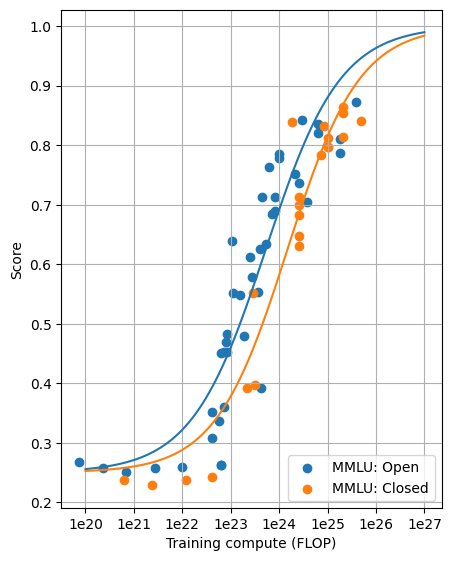

In [ ]:
results = defaultdict(dict)

# Benchmarks to plot
"""
TODO 
Consider error bars on benchmark results - error bars for one model would be similar for others.
"""
benchmarks_to_plot = ['MMLU']#, 'BBH']#, 'GPQA', 'SEAL Math', 'SEAL Coding', 'SEAL Instruction Following']

# Number of rows and columns for the subplot grid
n_rows = 1
n_cols = 2

# Creating a figure and axis objects
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15/1.75, 10/1.75))

# Flattening the axis array for easy iteration
axs = axs.flatten()

# Plotting each benchmark in its own subplot
for i, benchmark in enumerate(benchmarks_to_plot):
  for j, category in enumerate(['Open', 'Closed']):
    print(category, 'models')
    try:
      # Creating a subset with non-NaN values for the benchmark
      subset = df[df['Open/Closed'] == category]
      subset = subset[['System', 'log_compute', benchmark]]
      subset = subset.dropna()

      # Scatter plot
      axs[i].scatter(subset['log_compute'], subset[benchmark], label=f"{benchmark}: {category}")

      # Fit the custom sigmoid function to the data, if there are enough data points
      if len(subset) > 3:
        # Provide initial parameter estimates: x0 = median of x, k = 1
        initial_guesses = [subset['log_compute'].median(), 1]

        # Define bounds: x0 broadly around sensible compute OOMs, k > 0, b between 0 and 0.5
        bounds = ((15, 0.1), (32, np.inf))
        try:
          # Sigmoid with offset at the lowest performance, which we've calibrated as chance performance with a pseudo-entry.
          bench_sigmoid = lambda x, *p: custom_sigmoid(x, *p, b=df[df["System"]=="Random chance"][benchmark].values)
          popt, pcov = curve_fit(bench_sigmoid, subset['log_compute'], subset[benchmark], p0=initial_guesses, bounds=bounds, maxfev=10000)

          # Access the fitted parameters
          x0_optimal = popt[0]
          k_optimal = popt[1]

          # Calculate standard errors
          perr = np.sqrt(np.diag(pcov))
          x0_std_error = perr[0]
          k_std_error = perr[1]

          results[benchmark][category] = {'parameters': popt, 'covariance': pcov}

          # Print the parameters
          print(f"Optimal x0: {x0_optimal:.2f} ± {x0_std_error:.2f}")
          print(f"Optimal k: {k_optimal:.2f} ± {k_std_error:.2f}")

          # Generate x values for the curve
          x_values = np.linspace(20, 26 + 1, 100)
          # Calculate y values for the custom sigmoid curve
          y_values = bench_sigmoid(x_values, *popt)

          # Adding the custom sigmoid curve to the plot
          axs[i].plot(x_values, y_values, color=f'C{j}', label='')
        except RuntimeError as e:
          print(f"Could not fit a custom sigmoid for {benchmark}: {e}")

      axs[i].set_xlabel('Training compute (FLOP)')
      axs[i].set_ylabel('Score')
      axs[i].grid(True)
      axs[i].legend()
      # axs[i].set_xlim([22, 27])
    except ValueError as e:
      print(f"Could not fit a custom sigmoid for {benchmark}: {e}")

# Add Gemini to the legend
axs[i].legend(loc='lower right')

# Iterate over each axis in the axs array
for ax in axs:
  # Set the major locator for the x-axis to have a tick every 1 unit
  # ax.xaxis.set_major_locator(MultipleLocator(1))
  # Set the formatter for the x-axis
  ax.xaxis.set_major_formatter(FuncFormatter(custom_formatter))

#fig.suptitle('Estimated FLOP from benchmark scores: {:.2e}'.format(median_value), fontsize=16)

# Remove empty subplots if there are any
for j in range(i+1, len(axs)):
  fig.delaxes(axs[j])

# Adjusting layout to prevent overlap
plt.tight_layout()

plt.show()

In [ ]:
custom_sigmoid(26, 24.19, 1.17, 0.25)

0.9194587446406148

In [ ]:
custom_sigmoid(25.1, 23.67, 1.48, 0.25)

0.9193652372453741

In [ ]:
benchmark = 'MMLU'

root_scalar_options = {
    'method': 'bisect',  # Use the 'bisect' method
    'bracket': [15, 32]
}

closed_params = results[benchmark]['Closed']['parameters']
open_params = results[benchmark]['Open']['parameters']
target_flop = np.log10(5e25)
target_score = custom_sigmoid(target_flop, closed_params[0], closed_params[1], 0.25)  # closed model parameters

bench_sigmoid = lambda x, *p: custom_sigmoid(x, *p, b=df[df["System"]=="Random chance"][benchmark].values)
matching_flop = scipy.optimize.root_scalar(lambda x: bench_sigmoid(x, *open_params) - target_score, **root_scalar_options).root
print(target_flop - matching_flop)

0.39298041244975934
